In [69]:
!pip install pennylane
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader



%matplotlib inline

In [70]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(seed=42)

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [72]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [73]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


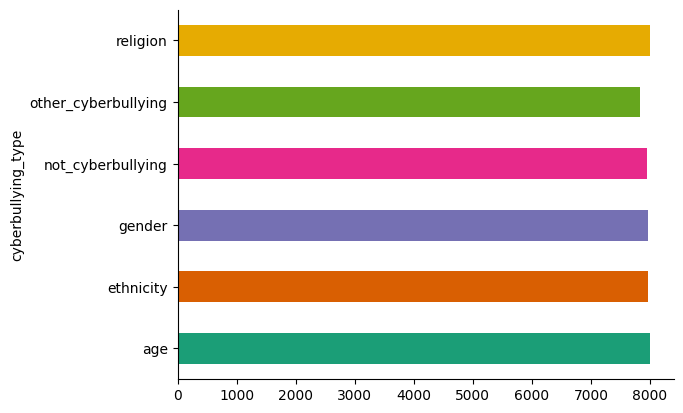

In [74]:
# @title cyberbullying_type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('cyberbullying_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [75]:
df[df == 'religion'] = '0'
df[df == 'age'] = '1'
df[df == 'gender'] = '2'
df[df == 'ethnicity'] = '3'
df[df == 'not_cyberbullying'] = '4'
df[df == 'other_cyberbullying'] = '5'
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
0,7998
1,7992
2,7973
3,7961
4,7945
5,7823


In [76]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",4
1,Why is #aussietv so white? #MKR #theblock #ImA...,4
2,@XochitlSuckkks a classy whore? Or more red ve...,4
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4
4,@RudhoeEnglish This is an ISIS account pretend...,4
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3
47688,Turner did not withhold his disappointment. Tu...,3
47689,I swear to God. This dumb nigger bitch. I have...,3
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3


In [77]:
import re
from typing import List

class TextPreprocessor:
    def __init__(self, max_len: int = None):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}  # Initialize with padding and unknown tokens
        self.max_len = max_len  # Max length for padding, can be set dynamically later

    # Step 1: Tokenization using regex (splits on non-alphanumeric characters)
    def tokenize(self, text: str) -> List[str]:
        return re.findall(r'\b\w+\b', text.lower())  # Split by word boundaries

    # Step 2: Build vocabulary by assigning indices to tokens
    def build_vocab(self, texts: List[str]):
        for text in texts:
            for token in self.tokenize(text):
                if token not in self.vocab:
                    self.vocab[token] = len(self.vocab)

    # Step 3: Convert tokens to integer sequences
    def text_to_sequence(self, text: str) -> List[int]:
        return [self.vocab.get(token, 1) for token in self.tokenize(text)]  # Use 1 for <UNK>

    # Step 4: Pad the sequences to the desired length
    def pad_sequence(self, sequence: List[int]) -> List[int]:
        if self.max_len is None:
            self.max_len = len(sequence)
        if len(sequence) < self.max_len:
            return sequence + [0] * (self.max_len - len(sequence))  # Padding with <PAD> (index 0)
        else:
            return sequence[:self.max_len]

    # Convert a list of texts to a padded tensor
    def texts_to_tensor(self, texts: List[str]) -> torch.Tensor:
        sequences = [self.text_to_sequence(text) for text in texts]
        padded_sequences = [self.pad_sequence(seq) for seq in sequences]
        return torch.tensor(padded_sequences)

In [78]:
preprocessor = TextPreprocessor(max_len = 100)

# Step 1: Build the vocabulary
preprocessor.build_vocab(df['tweet_text'])
print(f"Vocabulary: {preprocessor.vocab}")

# Step 2: Convert texts to padded tensors



Vocabulary: {'<PAD>': 0, '<UNK>': 1, 'in': 2, 'other': 3, 'words': 4, 'katandandre': 5, 'your': 6, 'food': 7, 'was': 8, 'crapilicious': 9, 'mkr': 10, 'why': 11, 'is': 12, 'aussietv': 13, 'so': 14, 'white': 15, 'theblock': 16, 'imacelebrityau': 17, 'today': 18, 'sunrise': 19, 'studio10': 20, 'neighbours': 21, 'wonderlandten': 22, 'etc': 23, 'xochitlsuckkks': 24, 'a': 25, 'classy': 26, 'whore': 27, 'or': 28, 'more': 29, 'red': 30, 'velvet': 31, 'cupcakes': 32, 'jason_gio': 33, 'meh': 34, 'p': 35, 'thanks': 36, 'for': 37, 'the': 38, 'heads': 39, 'up': 40, 'but': 41, 'not': 42, 'too': 43, 'concerned': 44, 'about': 45, 'another': 46, 'angry': 47, 'dude': 48, 'on': 49, 'twitter': 50, 'rudhoeenglish': 51, 'this': 52, 'an': 53, 'isis': 54, 'account': 55, 'pretending': 56, 'to': 57, 'be': 58, 'kurdish': 59, 'like': 60, 'islam': 61, 'it': 62, 'all': 63, 'lies': 64, 'raja5aab': 65, 'quickieleaks': 66, 'yes': 67, 'test': 68, 'of': 69, 'god': 70, 'that': 71, 'good': 72, 'bad': 73, 'indifferent': 74

In [79]:
train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)
train_features, train_labels = preprocessor.texts_to_tensor(list(train['tweet_text'])), torch.tensor([int(i) for i in train['cyberbullying_type']])
test_features, test_labels = preprocessor.texts_to_tensor(list(test['tweet_text'])), torch.tensor([int(i) for i in test['cyberbullying_type']])

In [80]:
class TextDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = data_x.float().to(device)
        self.y = data_y.float().to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


train_dataset = TextDataset(train_features, train_labels)
test_dataset = TextDataset(test_features, test_labels)

In [81]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [82]:
print(train_features[10].shape)

torch.Size([100])


In [83]:
num_qubits = 4

In [84]:
dev = qml.device("lightning.qubit", wires=range(num_qubits))

In [85]:
# dev = qml.device("default.qubit", wires=range(num_qubits))

In [86]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def quanvcirc(patch, weights, wires=range(num_qubits)):
    # Angle embedding of the patch (reshape to match expected size)
    qml.AngleEmbedding(patch, wires=wires, rotation='Y')

    # Apply RX rotations based on the weights
    qml.RX(weights[0][0], wires=0)
    qml.RX(weights[0][1], wires=1)

    # Apply CNOT gates
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])

    # Apply RY rotations based on the weights
    qml.RY(weights[1][0], wires=0)
    qml.RY(weights[1][1], wires=3)

    # Return the expectation values of Pauli-Z measurements on all qubits
    return [qml.expval(qml.PauliZ(w)) for w in wires]

Setting hyperparameters for QDI. The meaning of these parameters is illustrated by the following picture: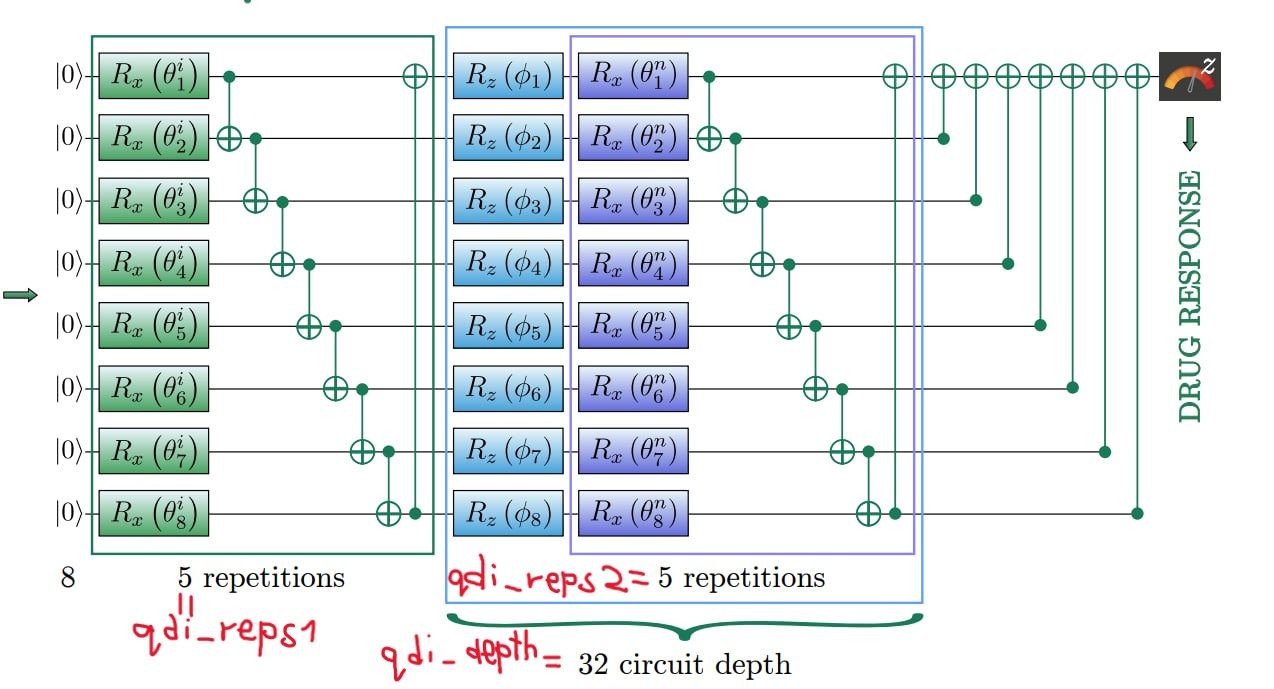

In [87]:
qdi_reps1 = 3
qdi_reps2 = 3
qdi_depth = 1

In [88]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            qml.Barrier()
        qml.Barrier()
    return [qml.expval(qml.PauliY(w)) for w in wires]

In [89]:
a = torch.stack(qdi_circuit(np.ones((qdi_reps1 + qdi_depth*qdi_reps2, num_qubits)), np.ones(num_qubits)))
a

tensor([0.4214, 0.3911, 0.5113, 0.2048])

In [90]:
t = torch.stack(quanvcirc(torch.randn(3, 4), torch.randn(2,2))).float()
t, t.T

(tensor([[ 0.2946, -0.4994,  0.4084],
         [-0.1177, -0.1167, -0.1145],
         [ 0.4080, -0.1145,  0.3423],
         [ 0.0417,  0.4343, -0.4563]]),
 tensor([[ 0.2946, -0.1177,  0.4080,  0.0417],
         [-0.4994, -0.1167, -0.1145,  0.4343],
         [ 0.4084, -0.1145,  0.3423, -0.4563]]))

In [91]:
m= t.T
m

tensor([[ 0.2946, -0.1177,  0.4080,  0.0417],
        [-0.4994, -0.1167, -0.1145,  0.4343],
        [ 0.4084, -0.1145,  0.3423, -0.4563]])

In [92]:
m[0].dtype

torch.float32

In [93]:
ze = torch.arange(0, 48).reshape(3, 4, 2, 2).float()
ze[:, :, 0, 1].dtype

torch.float32

In [94]:
ze[:, :, 0, 1] += m[0]
ze

tensor([[[[ 0.0000,  1.2946],
          [ 2.0000,  3.0000]],

         [[ 4.0000,  4.8823],
          [ 6.0000,  7.0000]],

         [[ 8.0000,  9.4080],
          [10.0000, 11.0000]],

         [[12.0000, 13.0417],
          [14.0000, 15.0000]]],


        [[[16.0000, 17.2946],
          [18.0000, 19.0000]],

         [[20.0000, 20.8823],
          [22.0000, 23.0000]],

         [[24.0000, 25.4080],
          [26.0000, 27.0000]],

         [[28.0000, 29.0417],
          [30.0000, 31.0000]]],


        [[[32.0000, 33.2946],
          [34.0000, 35.0000]],

         [[36.0000, 36.8823],
          [38.0000, 39.0000]],

         [[40.0000, 41.4080],
          [42.0000, 43.0000]],

         [[44.0000, 45.0417],
          [46.0000, 47.0000]]]])

In [95]:
class QuantumConvLayer(nn.Module):
    def __init__(self, kernel_size=2, stride=1, padding=0, out_channels=4):
        super(QuantumConvLayer, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.out_channels = out_channels

        # Trainable quantum circuit weights (2x2 matrix of weights per patch)
        self.weights = nn.Parameter(torch.randn(3, 3), requires_grad=True)

    def forward(self, x):
        batch_size, height, width = x.shape

        # Apply padding if specified
        if self.padding > 0:
            x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Output dimensions based on stride and padding
        output_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        # Initialize the output tensor (batch_size, out_channels, output_height, output_width)
        output = torch.zeros(batch_size, self.out_channels, output_height, output_width).to(device)

        # Perform the sliding window operation
        for i in range(0, height - self.kernel_size + 1, self.stride):
            for j in range(0, width - self.kernel_size + 1, self.stride):
                # Extract the current patch from the input tensor
                patch = x[:, i:i+self.kernel_size, j:j+self.kernel_size]
                  # Flatten patch to match quantum circuit input size
                # print(qml.draw(quanvcirc)(patch.reshape(batch_size, 4), self.weights))
                quantum_result = torch.stack(quanvcirc(patch.reshape(batch_size, 4), self.weights))
                # Apply the quantum circuit to the patch
                output[:, :, i, j] += quantum_result.T
        output = output.reshape(output.shape[0], -1)
        return output

In [96]:
class TestHybridModel(nn.Module):
    def __init__(self):
        super(TestHybridModel, self).__init__()
        self.quanv_layer = QuantumConvLayer()
        self.classical_layer = nn.Linear(324, 6)
    def forward(self, x):
        x = self.quantum_layer(x.reshape(batch_size, 10, 10))
        x = self.classical_layer(x)
        return x

In [97]:
# test_model = TestHybridModel()
# test_model.to(device)

In [98]:
# preds = test_model(torch.randn(batch_size, 10, 10))
# preds

In [99]:
from tqdm.notebook import tqdm

In [125]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].long().to(device)

            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].long().to(device)

            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

In [101]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss already has Softmax integrated, but !!! NLLLoss does not !!!

# optimizer = torch.optim.Adam(test_model.parameters(), lr=0.03)


In [102]:
# train_losses, \
#     test_losses, \
#     train_accuracy_arr, \
#     test_accuracy_arr = train(test_model, criterion=criterion,
#                               optimizer=optimizer,
#                               train_dataloader=train_dataloader,
#                               test_dataloader=test_dataloader,
#                               num_epochs=5)

In [103]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Combine weights for the gates and candidate
        self.q_params = nn.Parameter(torch.randn((qdi_reps1 + qdi_depth*qdi_reps2, 2)))
        self.W = nn.Parameter(torch.randn(input_size + hidden_size, 4 * hidden_size))
        self.b = nn.Parameter(torch.zeros(4 * hidden_size))


    def forward(self, x, hidden_state):
        h_prev, c_prev = hidden_state

        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)
        q_out = torch.zeros_like(combined, device=device)
        for j in range(batch_size):
          for i in range(0, q_out.size(1), 2):
              # print(torch.stack(qdi_circuit(self.q_params, combined[j][i:i+2], wires = range(2))).shape, q_out[j][i:i+2].shape)
              q_out[j][i:i+2] += torch.stack(qdi_circuit(self.q_params, combined[j][i:i+2], wires = range(2)))
        gates = q_out @ self.W + self.b

        input_gate, forget_gate, candidate_cell, output_gate = torch.split(gates, self.hidden_size, dim=1)

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        candidate_cell = torch.tanh(candidate_cell)
        output_gate = torch.sigmoid(output_gate)

        c_t = forget_gate * c_prev + input_gate * candidate_cell
        h_t = output_gate * torch.tanh(c_t)

        return h_t, c_t

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.cell = CustomLSTMCell(input_size, hidden_size)

    def forward(self, x, initial_state=None):
        batch_size, seq_size, _ = x.size()

        if initial_state is None:
            h_t = x.new_zeros(batch_size, self.hidden_size)
            c_t = x.new_zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = initial_state

        outputs = []
        for t in range(seq_size):
            x_t = x[:, t, :]
            h_t, c_t = self.cell(x_t, (h_t, c_t))
            outputs.append(h_t.unsqueeze(1))

        return h_t

In [104]:
class TestLSTMModel(nn.Module):
    def __init__(self):
        super(TestLSTMModel, self).__init__()
        self.quantum_layer = QuantumConvLayer()
        self.lstm_layer = CustomLSTM(2, 10)
        self.classical_layer = nn.Linear(10, 6)
    def forward(self, x):
        x = self.quantum_layer(x.reshape(batch_size, 10, 10))
        x = self.lstm_layer(x.reshape(batch_size, 162, 2))
        x = self.classical_layer(x)
        return x

In [105]:
# test_model = TestLSTMModel()
# test_model.to(device)

In [106]:
# optimizer = torch.optim.Adam(test_model.parameters(), lr=0.03)


In [107]:
# train_losses, \
#     test_losses, \
#     train_accuracy_arr, \
#     test_accuracy_arr = train(test_model, criterion=criterion,
#                               optimizer=optimizer,
#                               train_dataloader=train_dataloader,
#                               test_dataloader=test_dataloader,
#                               num_epochs=5)

In [127]:
import torch
import torch.nn as nn

class TestClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=2, stride=1, padding=0)
        self.lstm = nn.LSTM(input_size=2, hidden_size=10, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(10, 6)

    def forward(self, X):
        # Pass through Conv2D
        out = self.conv(X)

        # Reshape Conv2D output to fit LSTM input
        batch_size, channels, height, width = out.size()

        # Flatten channel, height, and width into a sequence
        out = out.view(batch_size, 162, 2)

        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, (hn, cn) = self.lstm(out)

        # Apply ReLU
        out = self.relu(out)

        # Pass the last hidden state to Linear layer
        out = self.fc(out[:, -1, :])

        return out



In [128]:
# model = TestClassicalModel().to(device)

# x_t = torch.randn(batch_size, 1, 10, 10).to(device)  # Ensure the input has the correct number of channels
# output = model(x_t)

In [129]:
test_model = TestClassicalModel()
test_model.to(device)

TestClassicalModel(
  (conv): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1))
  (lstm): LSTM(2, 10, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=10, out_features=6, bias=True)
)

In [130]:
x_t = torch.randn(batch_size, 1, 10, 10)
test_model(x_t)

tensor([[ 0.0065,  0.3913, -0.1958, -0.2854, -0.2579, -0.2446],
        [ 0.0297,  0.3979, -0.1825, -0.2960, -0.2574, -0.2560],
        [-0.0377,  0.3805, -0.2115, -0.2245, -0.2492, -0.2181],
        [ 0.0109,  0.3869, -0.1922, -0.2797, -0.2515, -0.2430],
        [-0.0331,  0.4060, -0.2137, -0.2596, -0.2770, -0.2347],
        [ 0.0060,  0.3878, -0.1939, -0.2771, -0.2541, -0.2387],
        [-0.0223,  0.3972, -0.2131, -0.2832, -0.2727, -0.2347],
        [-0.0531,  0.3986, -0.2258, -0.2554, -0.2781, -0.2209],
        [-0.0578,  0.4113, -0.2301, -0.2696, -0.2939, -0.2322],
        [ 0.0465,  0.3971, -0.1737, -0.3017, -0.2511, -0.2674],
        [-0.0410,  0.4086, -0.2144, -0.2414, -0.2773, -0.2391],
        [-0.0535,  0.3976, -0.2268, -0.2536, -0.2762, -0.2238],
        [ 0.0316,  0.3849, -0.1794, -0.2704, -0.2383, -0.2513],
        [ 0.0344,  0.3995, -0.1810, -0.3023, -0.2586, -0.2607],
        [ 0.0365,  0.3856, -0.1725, -0.2805, -0.2433, -0.2527],
        [ 0.0332,  0.3799, -0.1775, -0.2

In [131]:
optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)


In [132]:
train_features = train_features.reshape(-1, 10, 10).unsqueeze(1)
test_features = test_features.reshape(-1, 10, 10).unsqueeze(1)

In [133]:
train_features.shape

torch.Size([38154, 1, 10, 10])

In [134]:
class TextDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = data_x.float().to(device)
        self.y = data_y.float().to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


train_dataset = TextDataset(train_features, train_labels)
test_dataset = TextDataset(test_features, test_labels)

In [135]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [136]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train(test_model, criterion=criterion,
                              optimizer=optimizer,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

In [138]:
test_accuracy_arr

array([0.16479167, 0.16583333, 0.1715625 , 0.16479167, 0.1715625 ,
       0.16802083, 0.16479167, 0.16479167, 0.16197917, 0.2596875 ,
       0.27041667, 0.2834375 , 0.284375  , 0.2940625 , 0.27322917,
       0.27114583, 0.28885417, 0.29010417, 0.29520833, 0.29552083,
       0.29145833, 0.28052083, 0.2715625 , 0.295     , 0.2896875 ,
       0.29458333, 0.28802083, 0.29541667, 0.28875   , 0.285     ,
       0.29520833, 0.28510417, 0.29333333, 0.29416667, 0.29802083,
       0.27666667, 0.28354167, 0.29291667, 0.29      , 0.29520833])